# IMPORTS

In [118]:
# Imports  
import cv2
import os 
import tensorflow
import math

import keras
import matplotlib.pyplot as plot
import matplotlib.image as mpimg

import numpy as np
import glob
import pickle

from scipy.interpolate import interp1d

print('done')


done


In [127]:
# Hough Transform
def process_hough(imagepath, image, radius): # Returns (image, radius, success<true>) / (image, image.shape[0], success<false>)
    success = False
    image = cv2.resize(image, (640, 480), interpolation=cv2.INTER_LINEAR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(image, 11)
    ret, _ = cv2.threshold(
        gray, 0, 255, (cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    )

    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        1,
        50,
        param1=ret,
        param2=30,
        minRadius=20,
        maxRadius=100,
    )
    try:
        circles = circles[0, :, :]
        circles = np.int16(np.array(circles))
        for i in circles[:]:
            image = image[
                i[1] - i[2] - radius: i[1] + i[2] + radius, i[0] - i[2] - radius: i[0] + i[2] + radius
                # i[1] - i[2] : i[1] + i[2], i[0] - i[2] : i[0] + i[2]
            ]
            radius = i[2]
        success = True
        cv2.imshow("Image", image)
        # Wait for a key press (blocks execution)
        cv2.waitKey(0)
        
        return (image, radius, success)
    
    except:
        image[:] = 255
        print(f"{imagepath} -> No circles (iris) found.")
        success = False
        cv2.imshow("Image", image)
        # Wait for a key press (blocks execution)
        cv2.waitKey(0)
        return (image, image.shape[0], success)

In [128]:
# Fix Images
def remove_reflection(image): #returns image
    ret, mask = cv2.threshold(
        image, 150, 255, cv2.THRESH_BINARY
    )
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=1)
    image_rr = cv2.inpaint(
        image, dilation, 5, cv2.INPAINT_TELEA
    )

    return image_rr

In [129]:
# Daugman Rubber Sheet Model
def generate_rubber_sheet_model(image): #returns image
    q = np.arange(0.00, np.pi * 2, 0.01)
    inn = np.arange(0, int(image.shape[0] / 2), 1)

    cartisian_image = np.empty(shape=[inn.size, int(image.shape[1]), 3])
    m = interp1d([np.pi * 2, 0], [0, image.shape[1]])

    for r in inn:
        for t in q:
            polarX = int((r * np.cos(t)) + image.shape[1] / 2)
            polarY = int((r * np.sin(t)) + image.shape[0] / 2)
            try:
                cartisian_image[r][int(m(t) - 1)] = image[polarY][polarX]
            except:
                pass

    return cartisian_image.astype("uint8")

In [130]:
# Parse Iris Dataset
def parse_iris_dataset(keep_reflections): # Returns images(image, image_id, label)
    # eye_num_2 = 0
    # final_output = []
    # lables = []
    label = 0
    eye_images = []
    eye_L_images = []
    eye_R_images = []

    base_directory = 'Dataset/VISA_Iris/VISA_Iris'

    for path in glob.iglob(base_directory+'/*'):
        foldername = os.path.basename(path)
        label = foldername
        print('label: ' + label)
        image_id = 0

        # Process Left Eye
        for image_path in glob.iglob(path+'/L/*'):
            image = cv2.imread(image_path)
                
            image_hough_processed = process_hough(
                label, image, 50)  # hough transform

            if (keep_reflections):
                remove_reflection(image)
                
            (testimage, x, success) = image_hough_processed  
            if (success):
                eye_L_images.append(
                    [image_hough_processed, image_id, label])  # just left iris
                eye_images.append([image_hough_processed, image_id, label])
                image_id += 1
            else: pass
        print('L eye: ' + str(len(eye_L_images)))

        # Process Right Eye
        for image_path in glob.iglob(path+'/R/*'):
            image = cv2.imread(image_path)
                
            image_hough_processed = process_hough(
                label, image, 50)  # hough transform
            
            if (keep_reflections):
                remove_reflection(image_hough_processed)

            # image = cv2.resize(image, (400, 300))
            (testimage, x, success) = image_hough_processed  
            if (success):
                eye_R_images.append(
                    [image_hough_processed, image_id, label])  # just left iris
                eye_images.append([image_hough_processed, image_id, label])
                image_id += 1
            else: pass
        print('R iris: ' + str(len(eye_R_images)))

        # old code insert here
    print('iris images: ' + str(len(eye_images)))
    
    return eye_images

    # OLD CODE
    # for image_path in glob.iglob(path+'/L/*'):
    #     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    #     image = cv2.resize(image, (400, 300))
    #     eye_L_images.append([image, image_id, label]) #just left iris
    #     eye_images.append([image, image_id, label])
    #     image_id += 1
    # print('L eye: ' + str(len(eye_L_images)))

    # for image_path in glob.iglob(path+'/R/*'):
    #     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    #     image = cv2.resize(image, (400, 300))
    #     eye_R_images.append([image, image_id, label]) #just right iris
    #     eye_images.append([image, image_id, label])
    #     image_id += 1
    # print('R iris: ' + str(len(eye_R_images)))

In [131]:
# Proccess to Daugman
def proccess_images(eye_images):
    for eye_image in eye_images:
        (hough_information, image_id, label) = eye_image
        (image, radius, success) = hough_information
        image_daugman = generate_rubber_sheet_model(image)
        
        cv2.imwrite(
            'Processed/'+str(label)+ '.' + str(image_id) + '.Iris' + '.bmp',
            image_daugman
        )      

In [132]:
keep_reflections = False
eye_images = parse_iris_dataset(keep_reflections)
proccess_images(eye_images)

label: S0001_F_30


2024-04-23 16:23:21.293 Python[20453:296425] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


L eye: 19
S0001_F_30 -> No circles (iris) found.


error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/highgui/src/window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


: 

label: S0001_F_30
L eye: 19
R iris: 26
iris images: 45
iris image preprocessing done


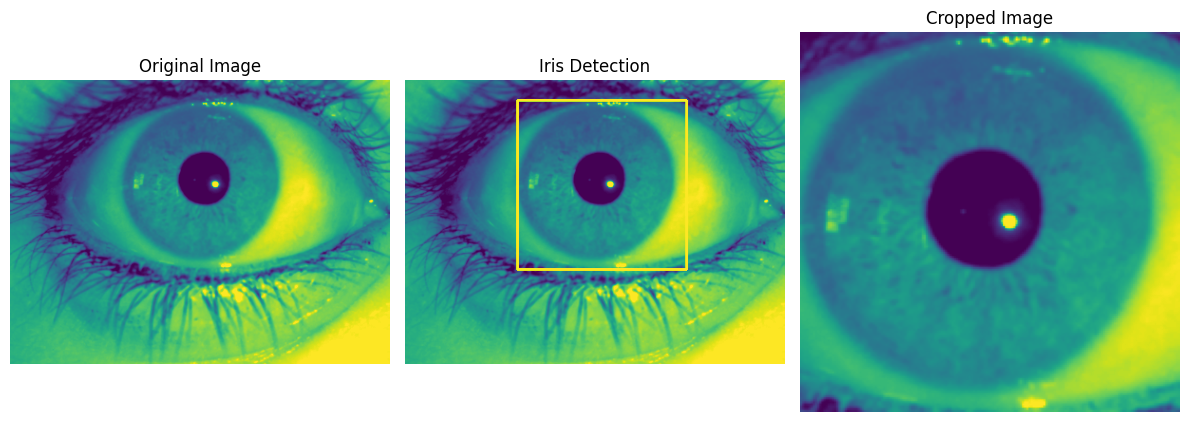

total_eyes_found =  45
total_eyes_found 2 =  0
total images:  45


In [ ]:
# OBSOLETE - Detect Iris using Iris Cascade
def detect_iris(eye_images, display):
    eye_num_2 = 0
    eyes_num = 0
    # explain how this works in presentation
    eye_cascade = cv2.CascadeClassifier('haarcascade_iris.xml')
    for eye_image in eye_images:
        (image, image_id, label) = eye_image
        image_id += 1
        eyes = eye_cascade.detectMultiScale(image, 1.1, 0)

        if len(eyes) > 1:  # idk what is happening
            eyes_num = eyes_num + 1
            maxium_area = -3
        
        for (x, y, width, height) in eyes:
            area = width * height

            if area > maxium_area:
                maxium_area = area
                maxium_width = width
                point_x = x
                point_y = y
                maxium_height = height
            
        image_unboxed = image.copy()

        image_cropped = image_unboxed[point_y:point_y + maxium_height,
                                      point_x:point_x + maxium_width,]

        image_boxed = cv2.rectangle(
            image,
            (point_x, point_y),
            (point_x + maxium_width, point_y + maxium_height),
            (255, 0, 0),
            2,
        )

        cv2.imwrite(
            'Processed/'+str(label)+ '.' + str(image_id) + '.Iris' + '.bmp',
            image_cropped
        )
        
    print("iris image preprocessing done")
    
    if (display):
        fig, axes = plot.subplots(1, 3, figsize=(12, 5))

        axes[0].imshow(image_unboxed)
        axes[0].set_title('Original Image')
        axes[0].axis('off')  # Hide axes for cleaner presentation

        axes[1].imshow(image_boxed)
        axes[1].set_title('Iris Detection')
        axes[1].axis('off')

        axes[2].imshow(image_cropped)
        axes[2].set_title('Cropped Image')
        axes[2].axis('off')

        plot.tight_layout()
        plot.show()

    print("total_eyes_found = ", eyes_num)
    print("total_eyes_found 2 = ", eye_num_2)
    print("total images: ", len(eye_images))

eye_images = parse_iris_dataset()
detect_iris(eye_images, 1)

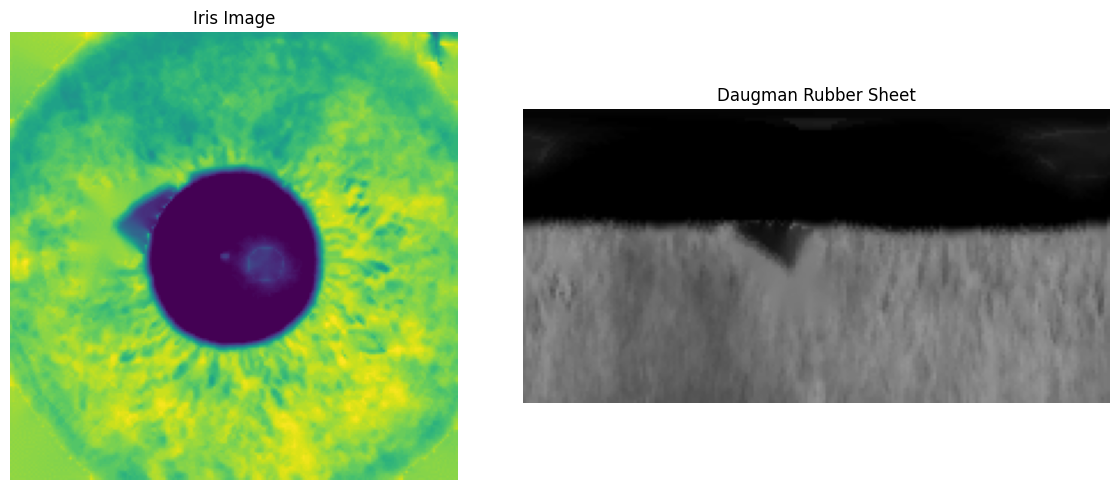

In [ ]:
#For Display
def processing(image_path, r):
    success = False
    image = cv2.imread(image_path)
    image = cv2.resize(image, (640, 480), interpolation=cv2.INTER_LINEAR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(image, 11)
    ret, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        1,
        50,
        param1=ret,
        param2=30,
        minRadius=20,
        maxRadius=100,
    )
    try:
        circles = circles[0, :, :]
        circles = np.int16(np.array(circles))
        for i in circles[:]:
            image = image[
                i[1] - i[2] - r : i[1] + i[2] + r, i[0] - i[2] - r : i[0] + i[2] + r
                # i[1] - i[2] : i[1] + i[2], i[0] - i[2] : i[0] + i[2]
            ]
            radius = i[2]
        success = True
        return image, radius, success
    except:
        image[:] = 255
        print(f"{image_path} -> No circles (iris) found.")
        success = False
        return image, image.shape[0], success

def generate_rubber_sheet_model(img):
    q = np.arange(0.00, np.pi * 2, 0.01)
    inn = np.arange(0, int(img.shape[0] / 2), 1)

    cartisian_image = np.empty(shape=[inn.size, int(img.shape[1]), 3])
    m = interp1d([np.pi * 2, 0], [0, img.shape[1]])

    for r in inn:
        for t in q:
            polarX = int((r * np.cos(t)) + img.shape[1] / 2)
            polarY = int((r * np.sin(t)) + img.shape[0] / 2)
            try:
                cartisian_image[r][int(m(t) - 1)] = img[polarY][polarX]
            except:
                pass

    return cartisian_image.astype("uint8")

def remove_reflection(img):
    ret, mask = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=1)
    dst = cv2.inpaint(img, dilation, 5, cv2.INPAINT_TELEA)
    return dst

imagepath = "/Users/ngzhengwei/Desktop/Current/CSCI158/FaceAndIris_Recognition/Dataset/VISA_Iris/VISA_Iris/S0001_F_30/L/3.bmp"
hough_information = processing(imagepath, 60)
(image1, radius, success) = hough_information
imageN = remove_reflection(image1)
sheet = generate_rubber_sheet_model(image1)
sheetN = generate_rubber_sheet_model(imageN)

fig, axes = plot.subplots(1,2, figsize=(12, 5))
axes[0].imshow(imageN)
axes[0].set_title('Iris Image')
axes[0].axis('off')  # Hide axes for cleaner presentation

axes[1].imshow(sheetN)
axes[1].set_title('Daugman Rubber Sheet')
axes[1].axis('off')

# axes[2].imshow(sheet)
# axes[2].set_title('Daugman Rubber Sheet')
# axes[2].axis('off')

plot.tight_layout()
plot.show()


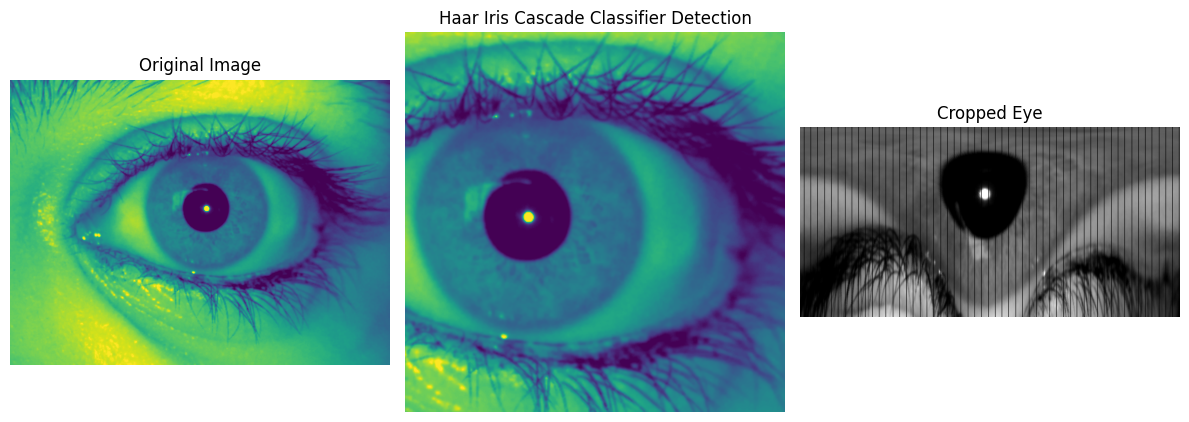

In [ ]:
# test

imagepath = "/Users/ngzhengwei/Desktop/Current/CSCI158/FaceAndIris_Recognition/Dataset/VISA_Iris/VISA_Iris/S0001_F_30/L/2.bmp"
# original_eye = cv2.imread(imagepath)
# cv2.imshow("frame1", original_eye)
eye_image = cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE)
# cv2.imshow("frame2", eye_image)


eye_circles = cv2.HoughCircles(
    eye_image, cv2.HOUGH_GRADIENT, 2, 100,  minRadius=90, maxRadius=200)

if eye_circles is not None:
    circle = eye_circles[0][0]
    iris_coordinates = (circle[0], circle[1])

if iris_coordinates is not None:
    x = int(iris_coordinates[0])
    y = int(iris_coordinates[1])

    w = int(round(circle[2]) + 10)
    h = int(round(circle[2]) + 10)

    # cv2.circle(original_eye, iris_coordinates, int(circle[2]), (255,0,0), thickness=2)
    image_hough_processed = eye_image[y-h:y+h, x-w:x+w]
    iris_image_to_show = cv2.resize(
        image_hough_processed, (image_hough_processed.shape[1]*2, image_hough_processed.shape[0]*2))

q = np.arange(0.00, np.pi*2, 0.01)  # theta
inn = np.arange(0, int(iris_image_to_show.shape[0]/2), 1)  # radius

cartisian_image = np.empty(
    shape=[inn.size, int(iris_image_to_show.shape[1]), 3])
m = interp1d([np.pi*2, 0], [0, iris_image_to_show.shape[1]])

for r in inn:
    for t in q:
        polarX = int((r * np.cos(t)) + iris_image_to_show.shape[1]/2)
        polarY = int((r * np.sin(t)) + iris_image_to_show.shape[0]/2)
        cartisian_image[r][int(m(t) - 1)] = iris_image_to_show[polarY][polarX]

iris_image_to_show
# im.save('eye.jpeg')
cartisian_image = cartisian_image.astype('uint8')
# im.save('cartesian_eye.jpeg')

fig, axes = plot.subplots(1, 3, figsize=(12, 5))
axes[0].imshow(eye_image)
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axes for cleaner presentation

axes[1].imshow(iris_image_to_show)
axes[1].set_title('Haar Iris Cascade Classifier Detection')
axes[1].axis('off')

axes[2].imshow(cartisian_image)
axes[2].set_title('Cropped Eye')
axes[2].axis('off')

plot.tight_layout()
plot.show()


# MAIN

In [ ]:

# eye_images = parse_iris_dataset()
# detect_iris(eye_images, 0) #param 2 is for display (1 = display, 0 = don't display)


label: S0054_F_19
L eye: 5
R iris: 0
label: S0007_F_23
L eye: 15
R iris: 21
label: S0003_M_32
L eye: 25
R iris: 31
label: S0050_M_30
L eye: 41
R iris: 56
label: S0004_M_16
L eye: 66
R iris: 82
label: S0018_F_43
L eye: 76
R iris: 92
label: S0021_M_25
L eye: 86
R iris: 102
label: S0001_F_30
L eye: 105
R iris: 128
label: S0005_M_11
L eye: 115
R iris: 148
label: S0038_M_50
L eye: 135
R iris: 168
label: S0044_M_56
L eye: 145
R iris: 178
label: S0047_M_48
L eye: 155
R iris: 188
label: S0013_M_34
L eye: 165
R iris: 198
label: S0010_M_24
L eye: 183
R iris: 218
label: S0040_M_31
L eye: 193
R iris: 228
label: S0048_M_34
L eye: 203
R iris: 238
label: S0043_M_20
L eye: 215
R iris: 248
label: S0045_M_32
L eye: 233
R iris: 266
label: S0049_M_34
L eye: 253
R iris: 276
label: S0027_M_41
L eye: 268
R iris: 286
label: S0032_M_68
L eye: 278
R iris: 296
label: S0011_M_23
L eye: 289
R iris: 313
label: S0015_M_26
L eye: 313
R iris: 342
label: S0041_F_22
L eye: 324
R iris: 357
label: S0053_M_24
L eye: 344
R 

: 